In [1]:
import sys
import numpy as np
from matplotlib import pyplot as plt
from joblib import Parallel, delayed
import seaborn as sns
import warnings
from nilearn import image
from nilearn.interfaces.fmriprep import load_confounds
sys.path.append('..')
from utils.data import Subject, load_participant_list

In [2]:
base_dir = '/home/ubuntu/data/learning-habits'
bids_dir = "/home/ubuntu/data/learning-habits/bids_dataset/derivatives/fmriprep-24.0.1"

all_sub_ids = load_participant_list(base_dir)

sub_ids = all_sub_ids

In [4]:
print('Number of subjects:', len(sub_ids))

Number of subjects: 62


In [5]:
subjects = [Subject(base_dir, sub_id, include_modeling=True, include_imaging=True, bids_dir=bids_dir) for sub_id in sub_ids]

/home/ubuntu/repos/learning-habits-analysis/notebooks/../utils/data.py:165: UserWarning: Last 1 trial(s) of block had no response, filling with 0
  warnings.warn(f"Last {n_missing} trial(s) of block had no response, filling with 0")


In [6]:
# get the reference images to know the shape of the data
N_learning = image.load_img(subjects[0].img.get('learning1')).shape[-1]
N_test = image.load_img(subjects[0].img.get('test')).shape[-1]

In [7]:
all_volumes = np.zeros((len(subjects), 3))
all_volumes[:, :2] = N_learning
all_volumes[:, 2] = N_test

In [50]:
fd_thresholds = [0.3, 0.5, 0.75, 1, 2]
std_dvars_thresholds = [1, 1.5, 2, 2.5, 3, 5]

def compute_valid_volumes_for_thresholds(fd_t, sd_t, scrub=3):
    """
    Returns a (len(subjects), 3) array of valid-volume proportions
    for the given FD & DVARS thresholds.
    """
    out = np.zeros((len(subjects), 3))
    for i, sub in enumerate(subjects):
        for j, run in enumerate(sub.runs):
            N_block = all_volumes[i, j]
            img_path = sub.img.get(run)
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=DeprecationWarning)
                _, sample_mask = load_confounds(
                    img_path,
                    strategy=('motion','high_pass','wm_csf','scrub'),
                    scrub=scrub,
                    fd_threshold=fd_t,
                    std_dvars_threshold=sd_t
                )
            valid = len(sample_mask) if sample_mask is not None else N_block
            out[i, j] = valid / N_block
    return out

In [25]:
# Run in parallel over all (fd, dvars) combos
results = Parallel(n_jobs=30)(
    delayed(compute_valid_volumes_for_thresholds)(fd_t, sd_t)
    for fd_t in fd_thresholds
    for sd_t in std_dvars_thresholds
)

In [26]:
n_fd = len(fd_thresholds)
n_sd = len(std_dvars_thresholds)
prop_valid = np.zeros((n_fd, n_sd, len(subjects), 3))

k = 0
for i_fd, fd_t in enumerate(fd_thresholds):
    for j_sd, sd_t in enumerate(std_dvars_thresholds):
        prop_valid[i_fd, j_sd] = results[k]
        k += 1

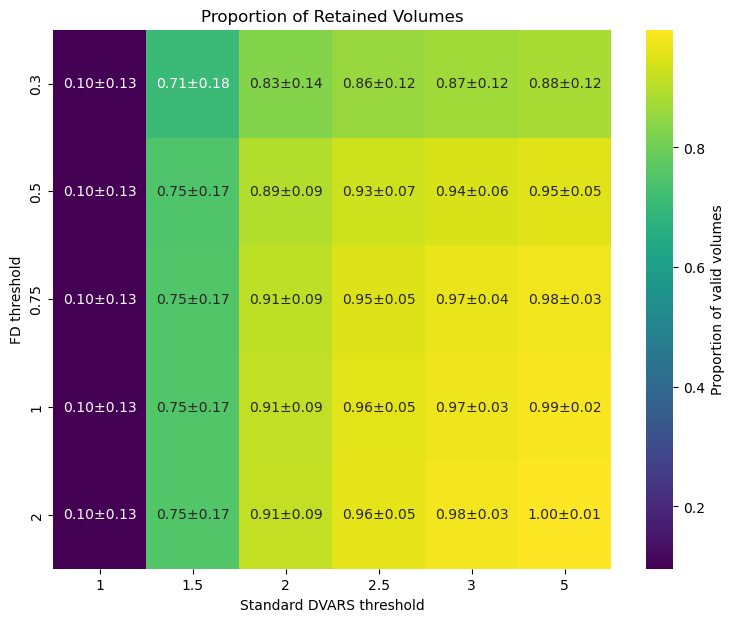

In [48]:
# Calculate mean and standard deviation
mean_prop_valid = prop_valid.mean(axis=(2, 3))
std_prop_valid = prop_valid.std(axis=(2, 3))

# Create the annotation text with mean and standard deviation
annot = np.array([["{:.2f}±{:.2f}".format(mean, std) for mean, std in zip(row_mean, row_std)] 
                  for row_mean, row_std in zip(mean_prop_valid, std_prop_valid)])

# Create the heatmap
plt.figure(figsize=(9, 7))  # Adjust figure size if needed
sns.heatmap(
    mean_prop_valid,  # Average over runs and subjects
    xticklabels=std_dvars_thresholds, 
    yticklabels=fd_thresholds, 
    cmap="viridis", 
    annot=annot,  # Add mean and std annotations
    fmt="",  # No additional formatting needed
    cbar_kws={'label': "Proportion of valid volumes"}  # Add label to colorbar
)

# Configure labels
plt.xlabel("Standard DVARS threshold")
plt.ylabel("FD threshold")
plt.title("Proportion of Retained Volumes")

plt.show()


In [56]:
# look at the effect of the scrub parameter 
fd_threshold = 0.5
std_dvars_threshold = 2
scrub = [1, 2, 3, 4, 5]

results = Parallel(n_jobs=5)(
    delayed(compute_valid_volumes_for_thresholds)(fd_threshold, std_dvars_threshold, s)
    for s in scrub
)

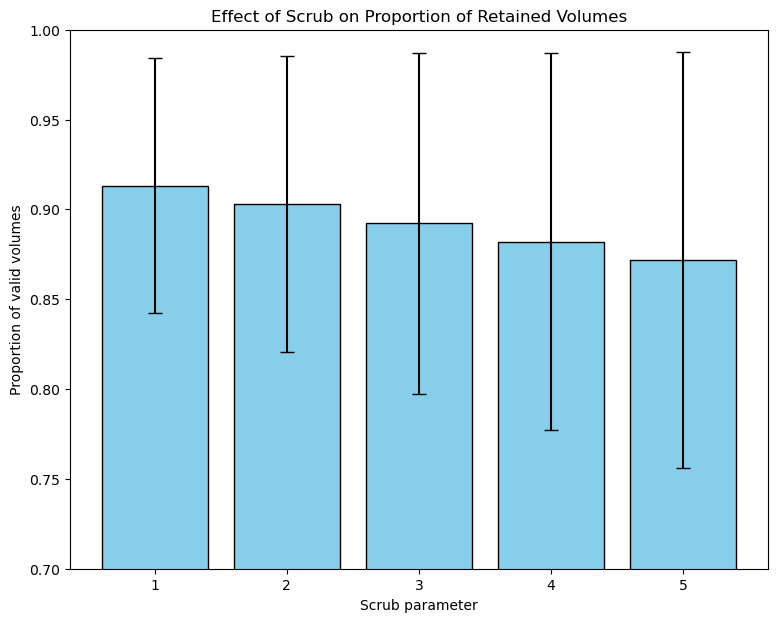

In [61]:
# Calculate mean and standard deviation for varying scrub
mean_prop_valid_scrub = np.array([result.mean(axis=(0, 1)) for result in results])
std_prop_valid_scrub = np.array([result.std(axis=(0, 1)) for result in results])

# Create the bar plot with error bars
plt.figure(figsize=(9, 7))  # Adjust figure size if needed
plt.bar(scrub, mean_prop_valid_scrub, yerr=std_prop_valid_scrub, capsize=5, color='skyblue', edgecolor='black')
plt.ylim((0.7,1))

# Configure labels
plt.xlabel("Scrub parameter")
plt.ylabel("Proportion of valid volumes")
plt.title("Effect of Scrub on Proportion of Retained Volumes")
plt.show()

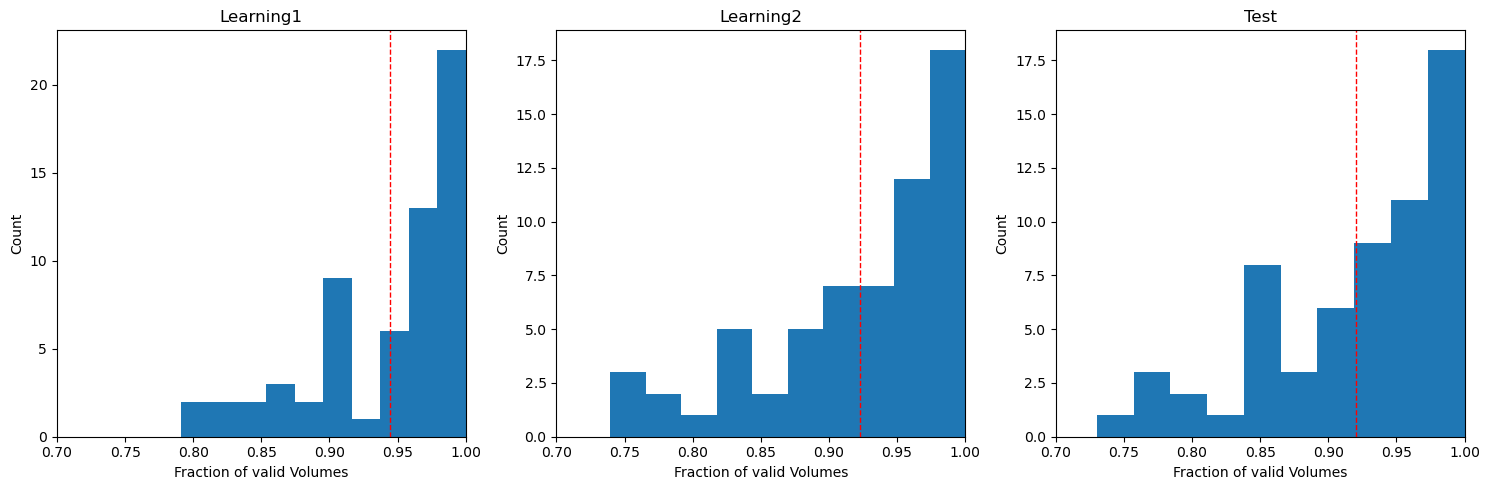

In [62]:
# Choose specific thresholds
chosen_fd_threshold_index = fd_thresholds.index(0.5)
chosen_std_threshold_index = std_dvars_thresholds.index(2.5)

# Extract valid volumes for the chosen thresholds
valid_volumes = prop_valid[chosen_fd_threshold_index, chosen_std_threshold_index]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].hist(valid_volumes[:, 0], bins=10, label='learning1')
axes[0].axvline(valid_volumes[:, 0].mean(), color='red', linestyle='dashed', linewidth=1)
axes[0].set_title('Learning1')
axes[0].set_xlabel('Fraction of valid Volumes')
axes[0].set_ylabel('Count')
axes[0].set_xlim(0.7, 1)

axes[1].hist(valid_volumes[:, 1], bins=10, label='learning2')
axes[1].axvline(valid_volumes[:, 1].mean(), color='red', linestyle='dashed', linewidth=1)
axes[1].set_title('Learning2')
axes[1].set_xlabel('Fraction of valid Volumes')
axes[1].set_ylabel('Count')
axes[1].set_xlim(0.7, 1)

axes[2].hist(valid_volumes[:, 2], bins=10, label='test')
axes[2].axvline(valid_volumes[:, 2].mean(), color='red', linestyle='dashed', linewidth=1)
axes[2].set_title('Test')
axes[2].set_xlabel('Fraction of valid Volumes')
axes[2].set_ylabel('Count')
axes[2].set_xlim(0.7, 1)

plt.tight_layout()
plt.show()

In [63]:
# exclusion threshold
max_scrub = 0.2

In [64]:
for run in range(3):
    subject_ids = [sub_ids[i] for i in range(len(sub_ids)) if valid_volumes[i, run] < 1-max_scrub]
    print(f'Run {run+1}: {len(subject_ids)} subjects with > {max_scrub} scrubbed volumes')
    print(f'Subject IDs: {subject_ids}')


Run 1: 1 subjects with > 0.2 scrubbed volumes
Subject IDs: ['51']
Run 2: 5 subjects with > 0.2 scrubbed volumes
Subject IDs: ['33', '45', '48', '52', '65']
Run 3: 5 subjects with > 0.2 scrubbed volumes
Subject IDs: ['09', '15', '33', '48', '51']
